This notebooks shows the cideMOD implementation of the SEI evolution in the negative electrode and compares it to the original reference [1] in which the implementation is based. The examples include the comparison of scenarios with different limiting processes (kinetic and diffusion) as well as cycling and OCV storage conditions.

[1] M. Safari et al 2009 J. Electrochem. Soc. 156 A145 doi: 10.1149/1.3043429

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

from cideMOD import (
    CellParser,
    CSI,
    Problem,
    Trigger,
    get_model_options
)

plt.rc('text', usetex=False)
plt.rc('font', family='serif')


## Cycling

In [2]:
V_app = 3.9
I_app = 0

days = 484
t_f = days *24*60*60 

In [3]:
n_cycles = 10
max_step = 60
min_step = 2
initial_step = min_step
time_adaptive_tol = 1e2
cycling = {
            "name": "Discharge Cycle",
            "type": "Cycle",
            "count": n_cycles,
            "steps": [
                {
                    "name": "Discharge",
                    "type": "Current", 
                    "value": -0.9, 
                    "unit": "A", 
                    "t_max": {"value": 2.5, "unit": "h"},
                    "store_delay": -1 ,
                    "max_step":max_step,
                    "min_step": min_step,
                    "initial_step":initial_step,
                    'time_adaptive_tol': time_adaptive_tol,
                    "events": [
                        {
                            "type": "Voltage",
                            "value": 2,  
                            "unit": "V",  
                            "atol": 1e-4, 
                            "rtol": 1e-3,
                            "goto": "Next" 
                        }
                    ]
                },
                {
                    "name": "Charge",
                    "type": "Current", 
                    "value": 0.9, 
                    "unit": "A", 
                    "t_max": {"value": 2.5, "unit": "h"},
                    "store_delay": -1,
                    "max_step":max_step,
                    "min_step": min_step,
                    "initial_step":initial_step,
                    'time_adaptive_tol':time_adaptive_tol,
                    "events": [
                        {
                            "type": "Voltage",
                            "value": 4.2,  
                            "unit": "V",  
                            "atol": 1e-4, 
                            "rtol": 1e-3,
                            "goto": "Next" 
                        }
                    ]
                },
                {
                    "name": "Charge",
                    "type": "Voltage", 
                    "value": 4.2, 
                    "unit": "V", 
                    "t_max": {"value": 2, "unit": "h"},
                    "store_delay": -1,
                    "max_step":max_step,
                    "min_step": min_step,
                    "initial_step":initial_step,
                    'time_adaptive_tol':time_adaptive_tol,
                    "events": [
                        {
                            "type": "Current",
                            "value": 0.05,  
                            "unit": "C",  
                            "atol": 1e-6, 
                            "rtol": 1e-4,
                            "goto": "Next" 
                        }
                    ]
                }
            ]}

cycling_test_plan = {
    'initial_state': {
        'SOC': 1,
        'exterior_temperature': 298
    },
    'steps': [cycling]
}

### Simulation settings
The SEI model is activated by setting the option `solve_SEI` to `True` in `ModelOptions` and choosing `SEI_model` limiting mechanism.

In [4]:
model = 'P2D'
case = "Safari_2009"
data_path = "../../data/data_{}".format(case)
cell_data = "params_cycling_lumped.json"

### Reaction limited case

In [5]:
model_options_rl = get_model_options(
    model=model,
    solve_SEI=True,
    SEI_model='solvent_diffusion',
    clean_on_exit=False,
    save_path=f"results/{case}_{model}_rl",
    raise_errors_on_exit=False)


Saving results to /home/fenicsx/shared/cideMOD/examples/scripts_paper/results/results_Safari_2009_P2D_rl


In [6]:
cell_rl = CellParser(cell_data, data_path, model_options_rl)
cell_rl.update_parameters({
    "cell.anode.SEI.porous.solvent_diffusion": 1.3e-15,
    "cell.anode.SEI.porous.rate_constant" : 1.36e-12
})


Negative electrode capacity: 1.697784
Positive electrode capacity: 2.163497
Cell capacity: 1.697784
Negative electrode capacity: 1.697784
Positive electrode capacity: 2.163497
Cell capacity: 1.697784


In [7]:
# Create the mesh
csi_rl = CSI(cell_rl, model_options_rl, cycling_test_plan)
status = csi_rl.run_test_plan()
problem_rl = csi_rl.problem


Building mesh for P2D problem with 3 components and 90 nodes
Finished mesh construction
Initial state:
	SOC : 1
	exterior_temperature : 298
Steps:
0 -  Cycle 'Discharge Cycle' repeats 10 times:
	 0 - CC_Discharge: Apply -0.9 A during 2 hours 30 minutes until [Voltage Trigger at 2 V]
	 1 - CC_Charge: Apply 0.9 A during 2 hours 30 minutes until [Voltage Trigger at 4.2 V]
	 2 - CV_Charge: Apply 4.2 V during 2 hours until [Current Trigger at 0.085 A]
Building problem setup
- Building cell parameters - Done
- Initializing state - Done   
- Build variational formulation - Done 
-- Cycle 'Discharge Cycle', iteration number 0 --
CC_Discharge: Apply -0.9 A during 2 hours 30 minutes until [Voltage Trigger at 2 V]
Voltage is 2 V at 1h 56min 28s                   

CC_Charge: Apply 0.9 A during 2 hours 30 minutes until [Voltage Trigger at 4.2 V]
Voltage is 4.2 V at 3h 28min 28s                 

CV_Charge: Apply 4.2 V during 2 hours until [Current Trigger at 0.085 A]
Current is 0.085 A at 4h 46min

### Diffusion limited case

In [8]:
model_options_dl = get_model_options(
    model=model,
    solve_SEI=True,
    SEI_model='solvent_diffusion',
    clean_on_exit=False,
    save_path=f"results/{case}_{model}_dl",
    raise_errors_on_exit=False)


Saving results to /home/fenicsx/shared/cideMOD/examples/scripts_paper/results/results_Safari_2009_P2D_dl


In [9]:
cell_dl = CellParser(cell_data, data_path, model_options_dl)
cell_dl.update_parameters({
    "cell.anode.SEI.porous.solvent_diffusion": 6.8e-21,
    "cell.anode.SEI.porous.rate_constant" : 1.36e-7
})


Negative electrode capacity: 1.697784
Positive electrode capacity: 2.163497
Cell capacity: 1.697784
Negative electrode capacity: 1.697784
Positive electrode capacity: 2.163497
Cell capacity: 1.697784


In [10]:
csi_dl = CSI(cell_data=cell_dl, simulation_options=model_options_dl, test_plan=cycling_test_plan)
status = csi_dl.run_test_plan()
problem_dl = csi_dl.problem


Building mesh for P2D problem with 3 components and 90 nodes
Finished mesh construction
Initial state:
	SOC : 1
	exterior_temperature : 298
Steps:
0 -  Cycle 'Discharge Cycle' repeats 10 times:
	 0 - CC_Discharge: Apply -0.9 A during 2 hours 30 minutes until [Voltage Trigger at 2 V]
	 1 - CC_Charge: Apply 0.9 A during 2 hours 30 minutes until [Voltage Trigger at 4.2 V]
	 2 - CV_Charge: Apply 4.2 V during 2 hours until [Current Trigger at 0.085 A]
Building problem setup
- Building cell parameters - Done                     
- Initializing state - Done                           
- Build variational formulation - Done                
-- Cycle 'Discharge Cycle', iteration number 0 --
CC_Discharge: Apply -0.9 A during 2 hours 30 minutes until [Voltage Trigger at 2 V]
Voltage is 2 V at 1h 56min 27s                        

CC_Charge: Apply 0.9 A during 2 hours 30 minutes until [Voltage Trigger at 4.2 V]
Voltage is 4.2 V at 3h 27min 44s                      

CV_Charge: Apply 4.2 V during 2 h

# Compare results

### SEI resistance

In [11]:
np.set_printoptions(formatter={'float_kind':'{:f}'.format})

safari_rl = np.genfromtxt("../../data/data_Safari_2009/reference_data/SEI_resistance_rl.txt", delimiter=' ')
safari_dl = np.genfromtxt("../../data/data_Safari_2009/reference_data/SEI_resistance_dl.txt", delimiter=' ')


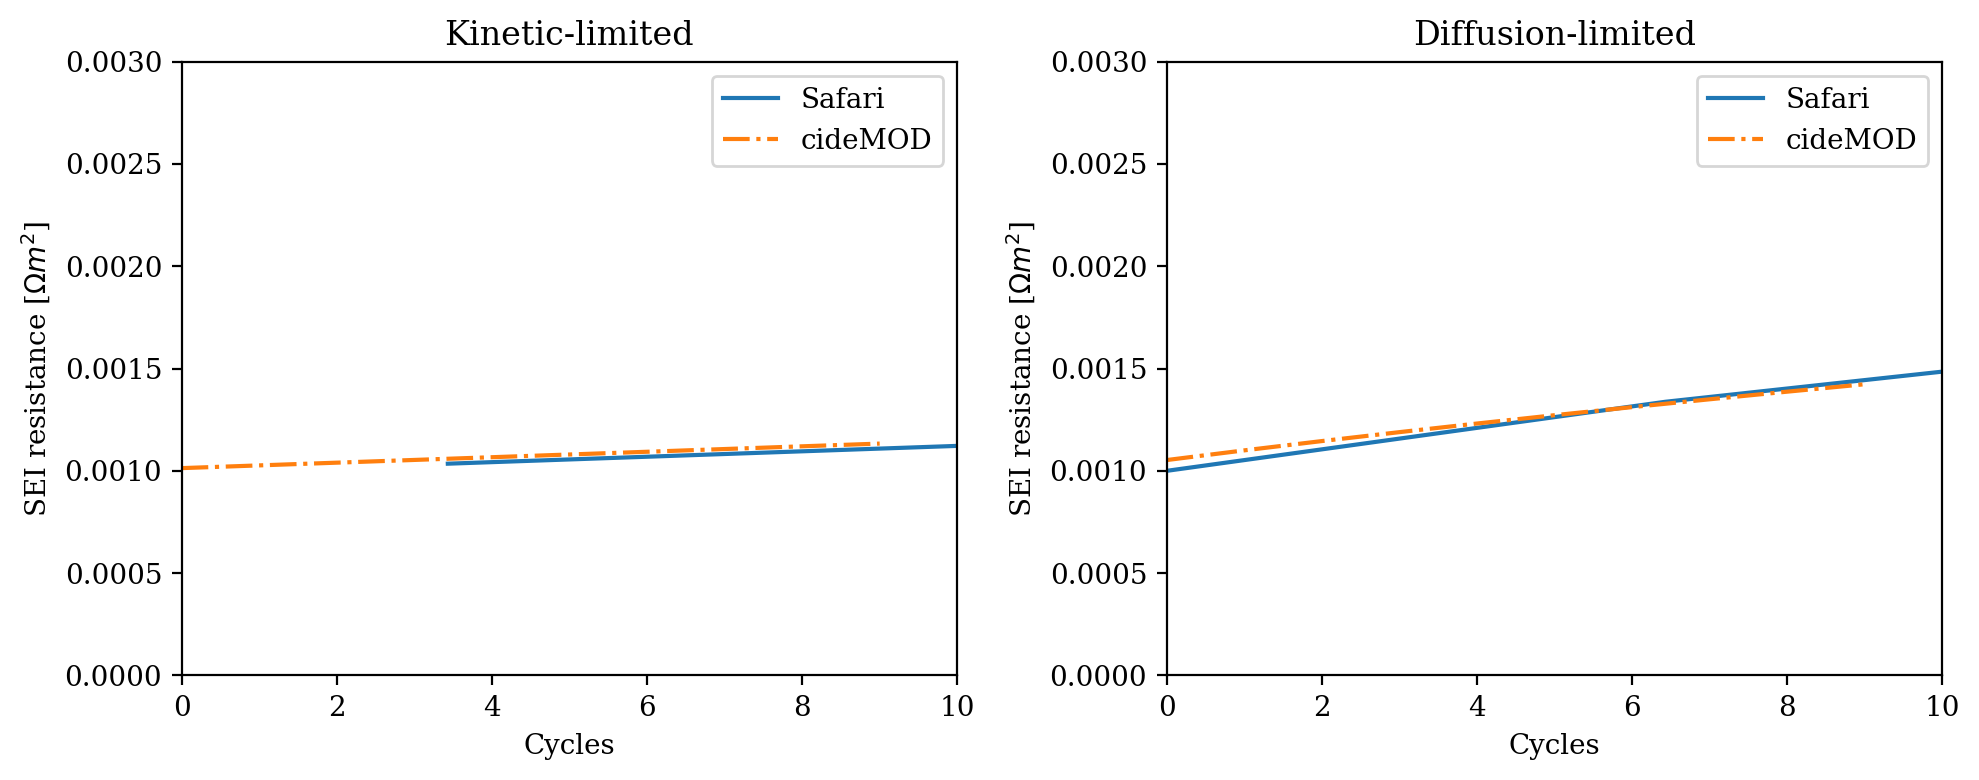

In [12]:
def sei_resistance(problem):
    cur = problem.get_global_variable('current')
    index = np.append(np.where(np.diff(cur)<(-0.5*1.8))[0], len(cur)-1)
    nCycles = len(index)
    cycles = np.arange(0, nCycles)
    thickness = problem.get_global_variable('delta_sei_a')
    av_thickness = np.array(thickness)[index]
    return cycles, av_thickness

def plot(problem, safari_file, title_name, n ):
    cycles, av_thickness = sei_resistance(problem)
    ax[n].plot(safari_file[:,0], safari_file[:,1], "-")
    ax[n].plot(cycles, av_thickness/problem.cell.anode.SEI.porous.kappa, "-.")
    ax[n].set_ylim([0, 0.003])
    ax[n].set_xlim([0, n_cycles])
    ax[n].set_xlabel("Cycles")
    ax[n].set_ylabel("SEI resistance [$\Omega m^2$]")
    ax[n].legend(["Safari", "cideMOD"], loc="best")
    ax[n].title.set_text(title_name)

ax=["ax1", "ax2"]
fig, (ax[0], ax[1]) = plt.subplots(1, 2, figsize=(10, 4), dpi=200)

plot(problem_rl, safari_rl, "Kinetic-limited", 0)
plot(problem_dl, safari_dl, "Diffusion-limited", 1)

plt.tight_layout()
plt.show()



### RMSE cycling

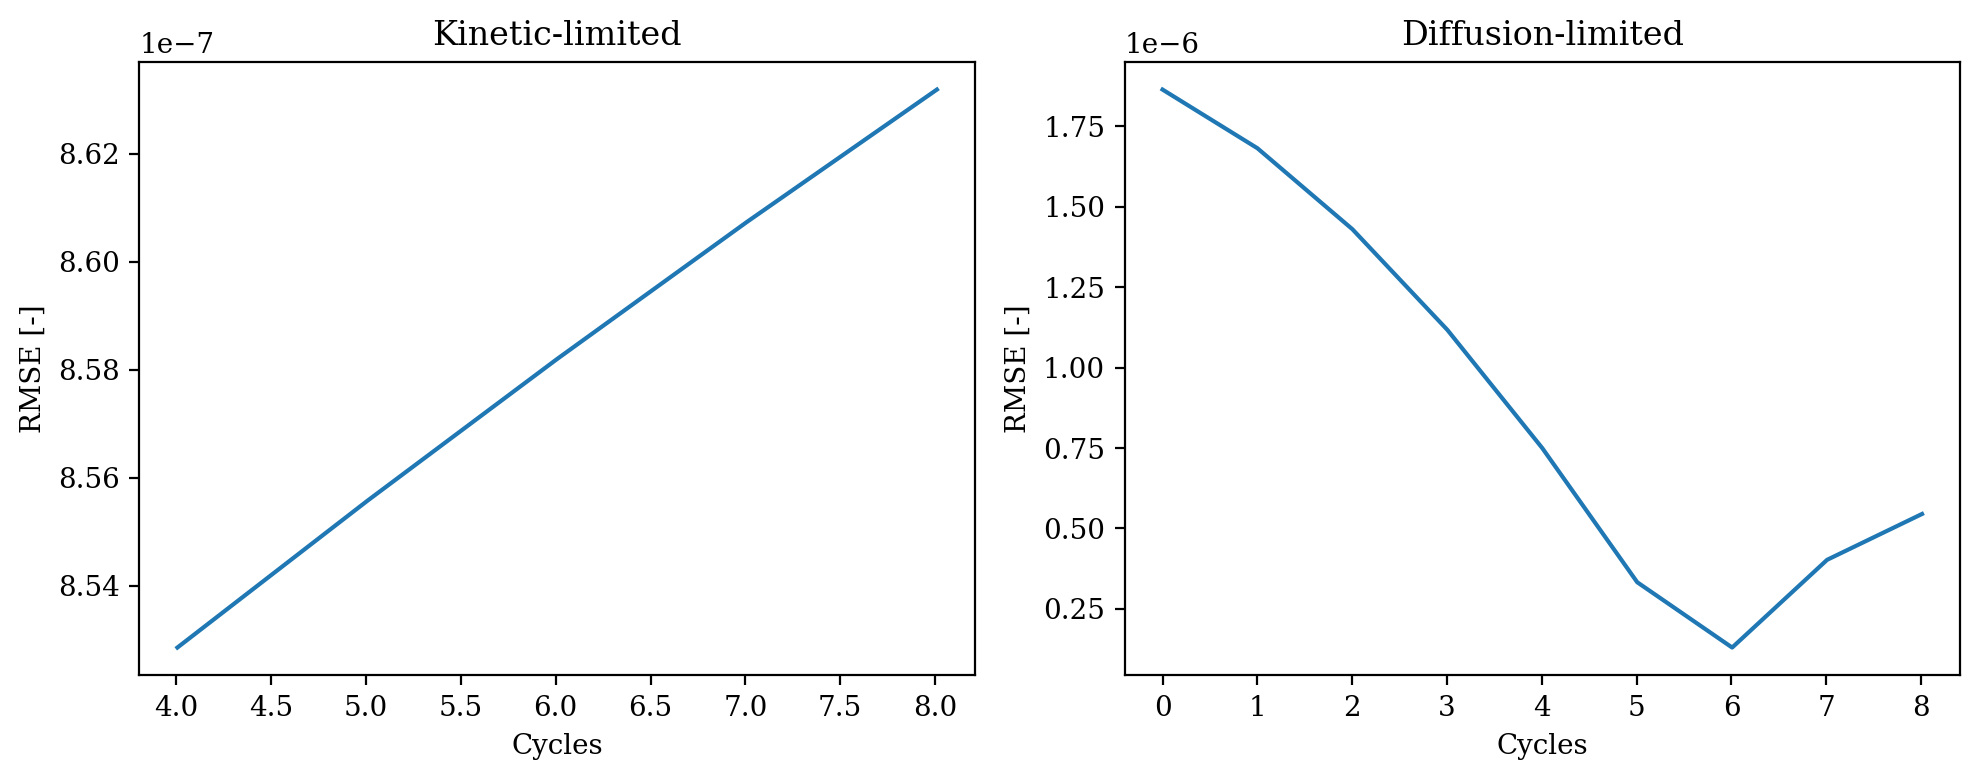

In [13]:
def plot_RMSE_cycling(problem, safari_file, title_name, n):
    time = np.linspace(0, 800, 800)
    cycles, av_thickness = sei_resistance(problem)
    real = interp1d(safari_file[:,0], safari_file[:,1], bounds_error=False)
    simulated = interp1d(cycles, av_thickness.flatten()/problem_dl.cell.anode.SEI.porous.kappa, bounds_error=False)
    ax[n].plot(time, np.sqrt((real(time)-simulated(time))**2/len(time)))
    ax[n].set_xlabel("Cycles")
    ax[n].set_ylabel("RMSE [-]")
    ax[n].title.set_text(title_name)

fig, (ax[0], ax[1]) = plt.subplots(1, 2, figsize=(10, 4), dpi=200)

plot_RMSE_cycling(problem_rl, safari_rl, "Kinetic-limited", 0)
plot_RMSE_cycling(problem_dl, safari_dl, "Diffusion-limited", 1)

plt.tight_layout()
plt.show()

### Voltage comparison

In [14]:
safari_rl_V = np.genfromtxt(
    "../../data/data_Safari_2009/reference_data/voltage_rl.txt", delimiter='\t')
safari_dl_V = np.genfromtxt(
    "../../data/data_Safari_2009/reference_data/voltage_dl.txt", delimiter='\t')


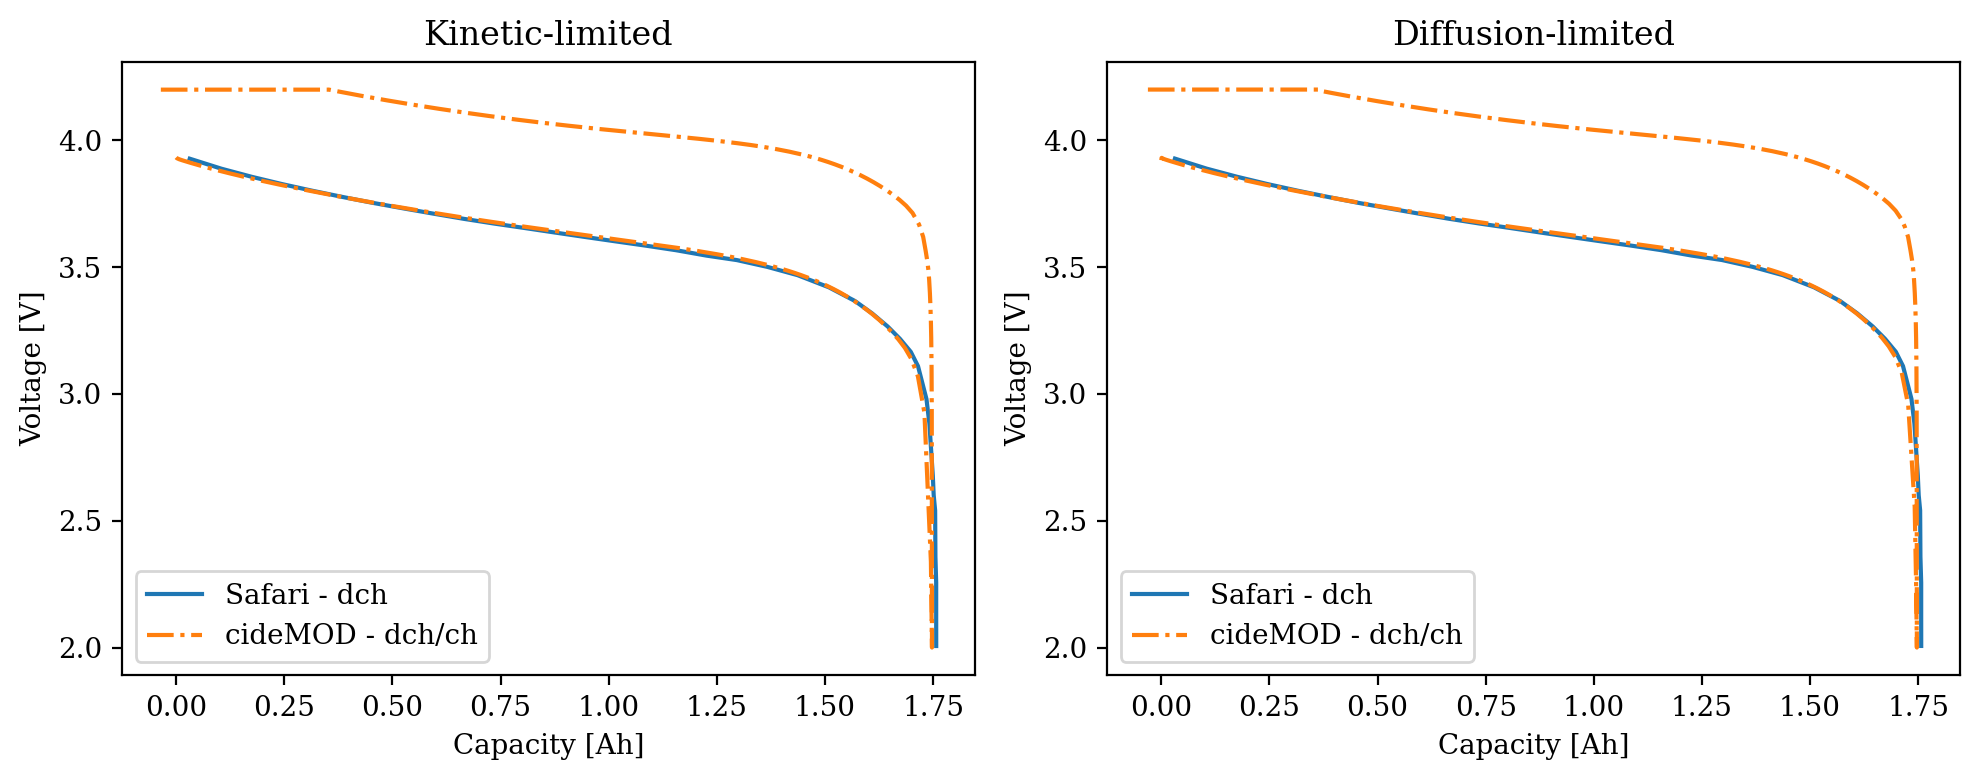

In [15]:
def plot_voltage(problem, safari_file, title_name, n):
    current = problem.get_global_variable('current')
    capacity = problem.get_global_variable('capacity')
    voltage = problem.get_global_variable('voltage')
    index = np.append(np.where(np.diff(current)<(-0.5*1.8))[0], len(current)-1)
    ax[n].plot(safari_file[:,0], safari_file[:,1], "-")
    ax[n].plot(capacity[0:index[0]], voltage[0:index[0]], "-.")
    ax[n].set_xlabel("Capacity [Ah]")
    ax[n].set_ylabel("Voltage [V]")
    ax[n].legend(["Safari - dch", "cideMOD - dch/ch"], loc="best")
    ax[n].title.set_text(title_name)

fig, (ax[0], ax[1]) = plt.subplots(1, 2, figsize=(10, 4), dpi=200)

plot_voltage(problem_rl, safari_rl_V, "Kinetic-limited", 0)
plot_voltage(problem_dl, safari_dl_V, "Diffusion-limited", 1)

plt.tight_layout()
plt.show()

## Compare OCV and cycling parameters

In [16]:
safari_Q_cycling = np.genfromtxt(
    "../../data/data_Safari_2009/reference_data/capacity_loss_cycling.txt", delimiter='\t')
safari_Q_OCV = np.genfromtxt(
    "../../data/data_Safari_2009/reference_data/capacity_loss_ocv.txt", delimiter='\t')

In [17]:
def run_problem(params, title_name):
    model_options = get_model_options(model=model,
                                    solve_SEI=True,
                                    SEI_model='solvent_diffusion',
                                    clean_on_exit=False,
                                    save_path=f"results/{case}_{model}_{title_name}",
                                    raise_errors_on_exit=False)
    cell = CellParser(params, data_path, model_options)
    problem = Problem(cell, model_options)
    problem.set_cell_state(SoC=1, T_ini=273 + 25, T_ext=273 + 25)
    problem.setup()
    v_min = Trigger(2.5, "v")
    status = problem.solve(
        min_step=5, max_step=30*24*3600, i_app=I_app, t_f=t_f, store_delay=-1, 
        adaptive=True, triggers=[v_min], time_adaptive_tol = 1e2
    )
    return problem

def plot_problem(problem, safari_file, title_name, n):
    time = np.array(problem.get_global_variable('time'))
    capacity_loss = np.array(problem.get_global_variable('Q_sei_a')).reshape((len(time),))
    ax[n].plot(safari_file[:,0], safari_file[:,1]*100, "-")
    ax[n].plot(time/3600/24, capacity_loss/1.8*100, "-")
    ax[n].set_xlabel("Time [days]")
    ax[n].set_ylabel(r"Capacity loss [\%]")
    ax[n].legend(["Safari", "cideMOD"], loc="best")
    ax[n].set_xlim([0, max(safari_file[:,0])])
    ax[n].title.set_text(title_name)


#### OCV

In [18]:
title_name_ocv = "OCV"
problem_ocv = run_problem("params_OCV.json", title_name_ocv)

Saving results to /home/fenicsx/shared/cideMOD/examples/scripts_paper/results/results_Safari_2009_P2D_OCV
Negative electrode capacity: 2.295595
Positive electrode capacity: 1.986885
Cell capacity: 1.986885
Building mesh for P2D problem with 3 components and 90 nodes
Finished mesh construction
Building problem setup
- Building cell parameters - Done                     
- Initializing state - Done                           
- Build variational formulation - Done                
Reached max time 41817600.00                          



#### Cycling

In [19]:
title_name_cy = "Cycling"
problem_cy = run_problem("params_cycling_lumped.json", title_name_cy)

Saving results to /home/fenicsx/shared/cideMOD/examples/scripts_paper/results/results_Safari_2009_P2D_Cycling
Negative electrode capacity: 1.697784
Positive electrode capacity: 2.163497
Cell capacity: 1.697784
Building mesh for P2D problem with 3 components and 90 nodes
Finished mesh construction
Building problem setup
- Building cell parameters - Done                     
- Initializing state - Done                           
- Build variational formulation - Done                
Reached max time 41817600.00                          



#### Plot

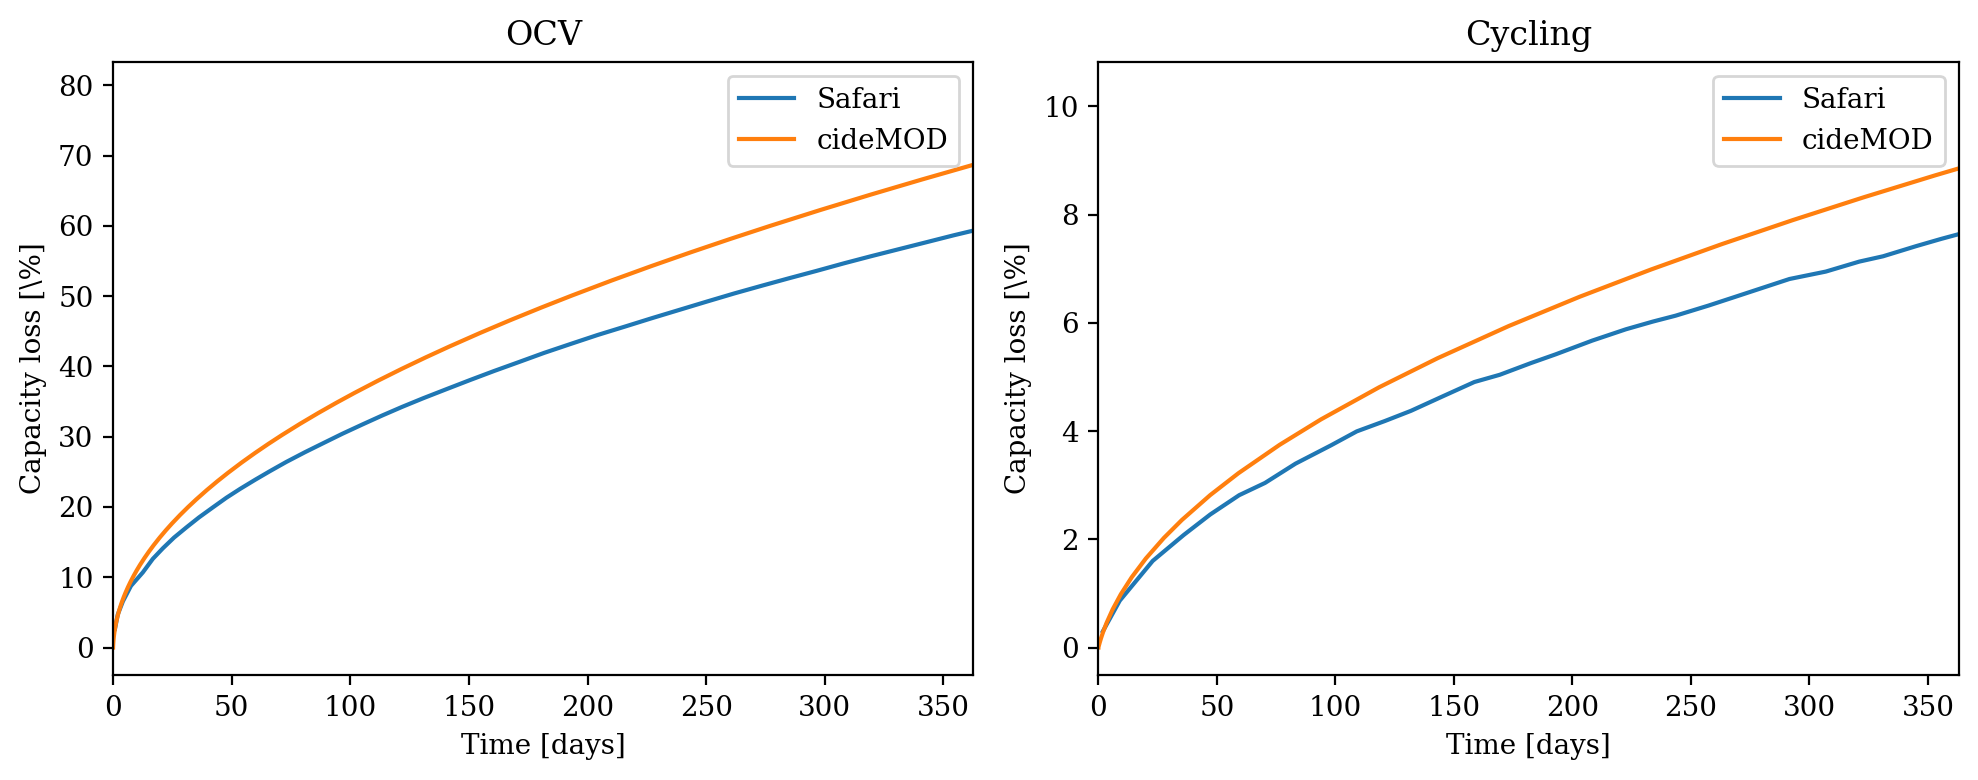

In [20]:
ax = ["ax1", "ax2"]
fig, (ax[0], ax[1]) = plt.subplots(1, 2, figsize=(10, 4), dpi=200)

plot_problem(problem_ocv, safari_Q_OCV, title_name_ocv, 0)
plot_problem(problem_cy, safari_Q_cycling, title_name_cy, 1)

plt.tight_layout()
plt.show()


### RSME

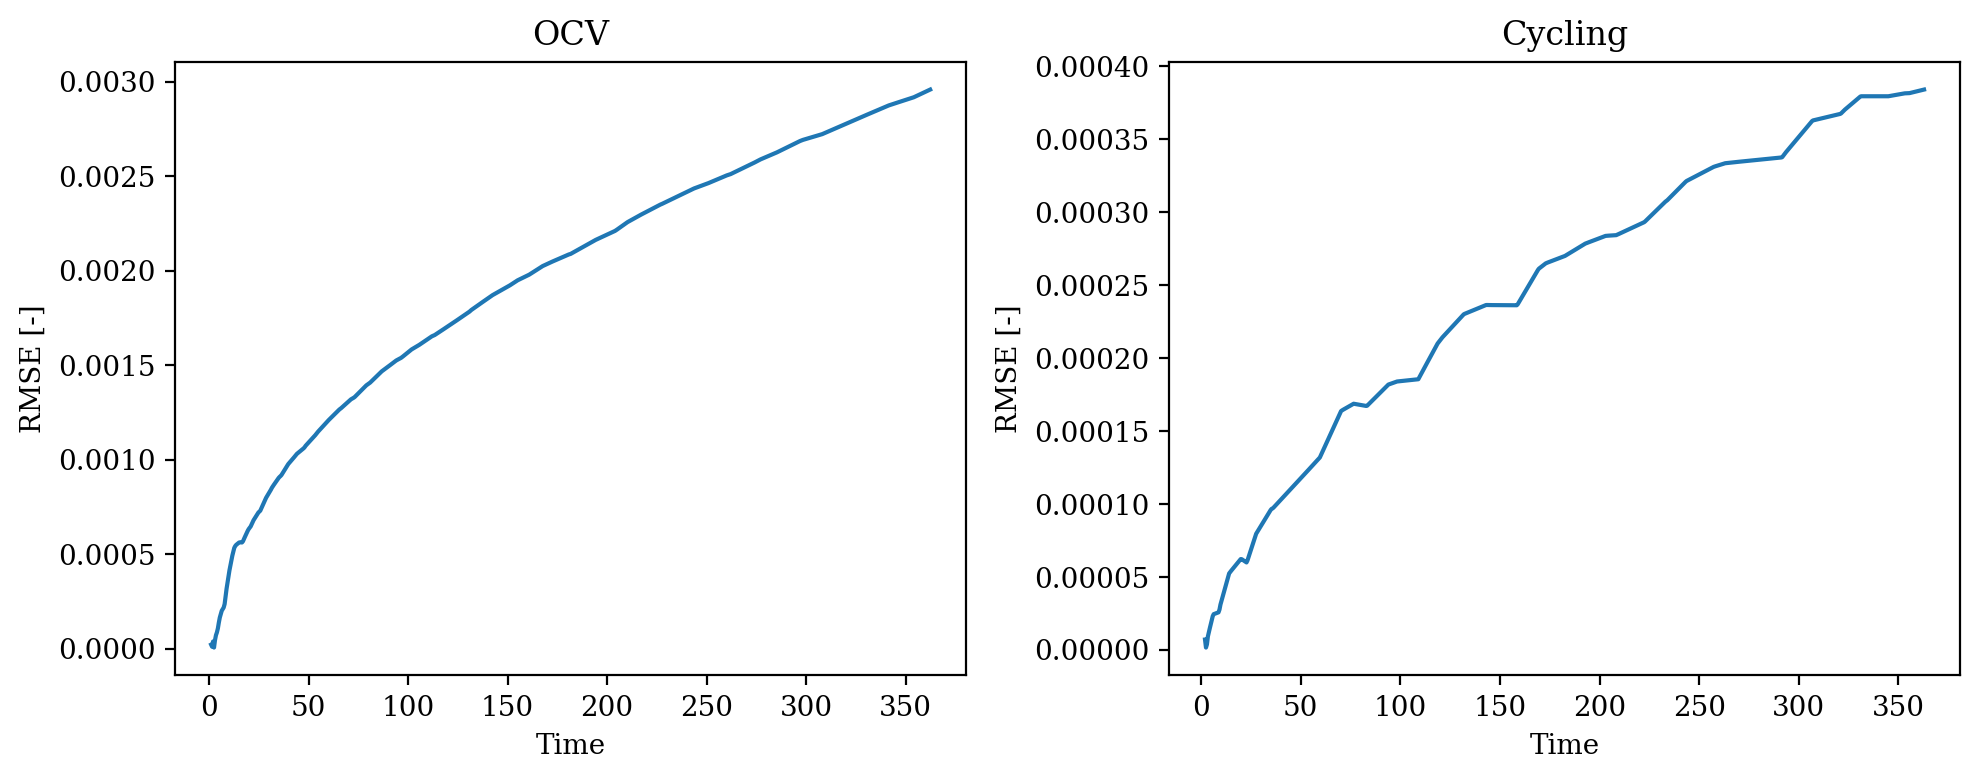

In [21]:
def plot_RMSE(time, problem, safari_file, title_name, n):
    _time = np.array(problem.get_global_variable('time'))
    capacity_loss = np.array(problem.get_global_variable('Q_sei_a')).reshape((len(_time),))
    real = interp1d(safari_file[:, 0], safari_file[:, 1], bounds_error=False)
    simulated = interp1d(_time / 3600 / 24, capacity_loss / 1.8, bounds_error=False)
    
    ax[n].plot(time, np.sqrt((real(time) - simulated(time))**2 / len(time)), "-")
    ax[n].set_xlabel("Time")
    ax[n].set_ylabel("RMSE [-]")
    ax[n].title.set_text(title_name)


time_ocv = np.array(problem_ocv.get_global_variable('time'))
time_cy = np.array(problem_cy.get_global_variable('time'))
time = np.linspace(0, max([safari_Q_cycling[:, 0][-1], time_cy[-1] / 3600 / 24,
                           safari_Q_OCV[:, 0][-1], time_ocv[-1] / 3600 / 24]), 1000)

fig, (ax[0], ax[1]) = plt.subplots(1, 2, figsize=(10, 4), dpi=200)
plot_RMSE(time, problem_ocv, safari_Q_OCV, title_name_ocv, 0)
plot_RMSE(time, problem_cy, safari_Q_cycling, title_name_cy, 1)

plt.tight_layout()
plt.show()